<a href="https://colab.research.google.com/github/enterausernamep/image_seg/blob/main/image_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras import backend as K
import zipfile
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Epoch 1/20
6/6 [==============================] - 63s 125ms/step - loss: 0.8592
Epoch 2/20
6/6 [==============================] - 1s 113ms/step - loss: 0.3714
Epoch 3/20
6/6 [==============================] - 4s 864ms/step - loss: 0.3116
Epoch 4/20
6/6 [==============================] - 9s 1s/step - loss: 0.3243
Epoch 5/20
6/6 [==============================] - 10s 2s/step - loss: 0.2936
Epoch 6/20
6/6 [==============================] - 10s 2s/step - loss: 0.3142
Epoch 7/20
6/6 [==============================] - 9s 2s/step - loss: 0.3259
Epoch 8/20
6/6 [==============================] - 10s 2s/step - loss: 0.3053
Epoch 9/20
6/6 [==============================] - 11s 2s/step - loss: 0.2984
Epoch 10/20
6/6 [==============================] - 10s 2s/step - loss: 0.3141
Epoch 11/20
6/6 [==============================] - 7s 1s/step - loss: 0.3015
Epoch 12/20
6/6 [==============================] - 8s 979ms/step - loss: 0.3101
Epoch 13/20
6/6 [==============================] - 9s 976ms/step - 

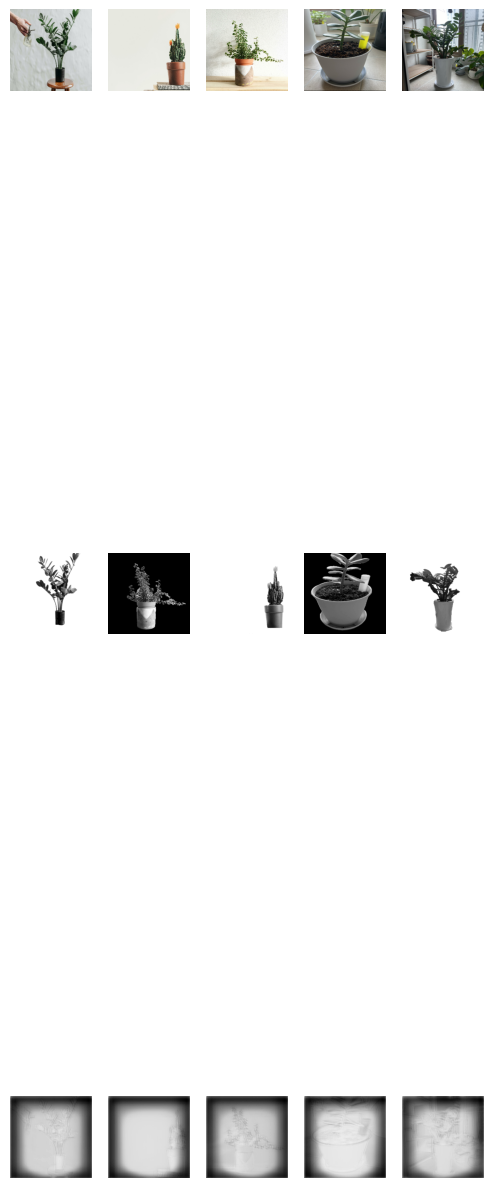

Mask 1 resolution: 5755 x 3836 pixels
Mask 2 resolution: 3022 x 3022 pixels
Mask 3 resolution: 5798 x 3870 pixels
Mask 4 resolution: 663 x 882 pixels
Mask 5 resolution: 577 x 769 pixels
Predicted_mask:
Image Width: 5757
Image Height: 3838
Horizontal DPI: 72
Vertical DPI: 72


Image Width: 3024
Image Height: 3024
Horizontal DPI: 72
Vertical DPI: 72


Image Width: 5800
Image Height: 3872
Horizontal DPI: 72
Vertical DPI: 72


Image Width: 665
Image Height: 884
Horizontal DPI: 72.0
Vertical DPI: 72.0


Image Width: 579
Image Height: 771
Horizontal DPI: 95.9866
Vertical DPI: 95.9866


Test Image 1: 객체 픽셀 길이 = 22076180, 가로 픽셀 길이 = 203.00597145591374 cm, 세로 픽셀 길이 = 135.33731430394246 cm
Test Image 2: 객체 픽셀 길이 = 9132484, 가로 픽셀 길이 = 106.60944444444443 cm, 세로 픽셀 길이 = 106.60944444444442 cm
Test Image 3: 객체 픽셀 길이 = 22438260, 가로 픽셀 길이 = 204.52298880028593 cm, 세로 픽셀 길이 = 136.53672631632878 cm
Test Image 4: 객체 픽셀 길이 = 584766, 가로 픽셀 길이 = 23.397904664912485 cm, 세로 픽셀 길이 = 31.103380035763355 cm
Test Ima

In [2]:
# 하이퍼파라미터 설정
epoch_num = 20
learning_rate = 0.001
buffer_size = 110
batch_size = 16
img_height = 256
img_width = 256
img_channel = 4

# 데이터 경로 설정
data_dir = '/content/drive/MyDrive/Colab Notebooks/'  # 기본 경로
train_dir = os.path.join(data_dir, 'train2')  # 훈련이미지수: 107개
test_dir = os.path.join(data_dir, 'test') # 테스트이미지수: 5개

# 이미지 파일 경로 및 라벨 가져오기 함수 정의
def get_file_paths_and_labels(folder_path):
    image_paths = []
    mask_paths = []
    labels = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isdir(file_path):
            if 'mask' in file_path:
                for maskfile_name in os.listdir(file_path):
                    maskfile_path = os.path.join(file_path, maskfile_name)
                    if not maskfile_path.endswith(".ipynb_checkpoints"):  # '.ipynb_checkpoints'로 끝나는 경로는 제외
                        mask_paths.append(maskfile_path)
        else:
            image_paths.append(file_path)
            labels.append(os.path.basename(file_name))
    return image_paths, mask_paths, labels

# 각 데이터셋에 대한 파일 경로 및 라벨 가져오기
train_image_paths, train_mask_paths, train_labels = get_file_paths_and_labels(train_dir)
test_image_paths, test_mask_paths, test_labels = get_file_paths_and_labels(test_dir)

# 데이터셋 생성
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths, test_labels))
train_dataset = train_dataset.repeat() # 마지막 batch_size를 채우기 위함.

# 전처리 함수 정의
def preprocess_image_and_mask(image_path, mask_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (img_height, img_width))
    alpha = tf.ones_like(image[:, :, :1]) * 255  # 알파 채널 생성 (전부 255로 설정하여 완전히 불투명하도록 함)
    image = tf.concat([image, alpha], axis=-1)
    image = tf.cast(image, tf.float32) / 255

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, (img_height, img_width))
    mask = tf.cast(mask, tf.float32) / 255.0
    alpha = tf.ones_like(mask[:, :, :1])
    mask = tf.concat([mask, alpha], axis=-1)

    return image, mask

# 전처리 함수 적용
train_dataset = train_dataset.map(preprocess_image_and_mask)
test_dataset = test_dataset.map(preprocess_image_and_mask)

# 데이터셋 셔플링, 배치화 및 반복 적용
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size).batch(batch_size).prefetch(batch_size)
train_dataset = train_dataset.repeat() # 마지막 batch_size를 채우기 위함.

# unet 모델 정의
def UNet():
    inputs = tf.keras.layers.Input(shape=(img_height, img_width, img_channel))

    # 인코더 부분
    conv0 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(inputs) # 256
    pool0 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv0) # 128

    conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(pool0) # 128
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1) # 64

    conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(pool1) # 64
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2) # 32

    conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool2) # 32
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3) # 16

    conv4 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool3) # 16
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4) # 8

    conv5 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool4) # 8
    pool5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv5) # 4

    conv6 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(pool5) # 4

    # 디코더 부분
    up1 = tf.keras.layers.Conv2DTranspose(512, 2,padding='same')(conv6)  # 4
    upsamp0 = tf.keras.layers.UpSampling2D((2,2))(up1) # 8
    up1 = tf.keras.layers.concatenate([upsamp0, conv5], axis=3)
    conv7 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(up1)

    up2 = tf.keras.layers.Conv2DTranspose(256, 2,padding='same')(conv7) # 8
    upsamp1 = tf.keras.layers.UpSampling2D((2,2))(up2) # 16
    up2 = tf.keras.layers.concatenate([upsamp1, conv4], axis=3)
    conv8 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(up2)

    up3 = tf.keras.layers.Conv2DTranspose(128, 2 ,padding='same')(conv8) # 16
    upsamp2 = tf.keras.layers.UpSampling2D((2,2))(up3) # 32
    up3 = tf.keras.layers.concatenate([upsamp2, conv3], axis=3)
    conv9 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(up3)

    up4 = tf.keras.layers.Conv2DTranspose(64, 2,padding='same')(conv9) # 32
    upsamp3 = tf.keras.layers.UpSampling2D((2,2))(up4) # 64
    up4 = tf.keras.layers.concatenate([upsamp3, conv2], axis=3)
    conv10 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up4)

    up5 = tf.keras.layers.Conv2DTranspose(32, 2,padding='same')(conv10) # 64
    upsamp4 = tf.keras.layers.UpSampling2D((2,2))(up5) # 128
    up5 = tf.keras.layers.concatenate([upsamp4, conv1], axis=3)
    conv11 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(up5)

    up6 = tf.keras.layers.Conv2DTranspose(16, 2,padding='same')(conv11) # 128
    upsamp5 = tf.keras.layers.UpSampling2D((2,2))(up6) # 256
    up6 = tf.keras.layers.concatenate([upsamp5, conv0], axis=3)
    conv12 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(up6)

    outputs = tf.keras.layers.Conv2D(2, 1, activation='sigmoid')(conv12)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# UNet 모델 생성
unet_model = UNet()

# 모델 컴파일
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                   loss='binary_crossentropy',
                   metrics=[])

# 데이터셋 크기 계산
train_data_size = len(train_image_paths)
steps_per_epoch = train_data_size // batch_size

# 모델 훈련
unet_model.fit(train_dataset, epochs=epoch_num, steps_per_epoch= steps_per_epoch)

# 테스트 데이터에서 이미지와 마스크 가져오기
test_image, test_mask = next(iter(test_dataset))

# 모델을 사용하여 마스크 예측
predicted_mask = unet_model.predict(test_image)

# IoU 계산 함수 정의
def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# IoU 계산
iou_scores = []
for i in range(len(test_image)):
    iou = compute_iou(test_mask[i][:,:,0], predicted_mask[i][:,:,0])
    iou_scores.append(iou)

# IoU 평균 계산
mean_iou = np.mean(iou_scores)
print("Mean IoU:", mean_iou)

def remove_boundary(mask):
    mask = mask[1:-1, 1:-1]  # 경계 제거
    return mask

plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(3, batch_size, i + 1)
    plt.imshow(test_image[i])
    plt.axis('off')

    plt.subplot(3, batch_size, batch_size + i + 1)
    plt.imshow(test_mask[i][:, :, 0].numpy().squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(3, batch_size, 2 * batch_size + i + 1)
    binary_mask =(predicted_mask[i][:, :, 0])
    binary_mask = remove_boundary(binary_mask)  # 경계 제거
    plt.imshow(binary_mask, cmap='gray')
    plt.axis('off')

plt.show()

# 후처리 함수 정의
def post_process_mask_with_resolution(predicted_mask, image_paths):
    resized_masks = []
    for i, mask in enumerate(predicted_mask): # 예측된 마스크 하나씩 뽑아서
        image = Image.open(image_paths[i]) # test_image 에서 하나씩 이미지 받아와서
        width, height = image.size # 이미지 가로 세로 해상도 받고
        mask = tf.image.resize(mask, (height, width), method=tf.image.ResizeMethod.BILINEAR) # 이미지 사이즈 재조정
        #mask = tf.squeeze(mask)
        mask = tf.where(mask >= 0.5, 1.0, 0.0)  # 임계값을 기준으로 이진화
        mask = remove_boundary(mask)  # 경계 제거
        resized_masks.append(mask)
    return resized_masks

# 후처리를 통해 예측된 마스크를 입력 이미지와 동일한 크기로 조정
resized_masks = post_process_mask_with_resolution(predicted_mask, test_image_paths)

# 마스크 해상도 출력
for i, mask in enumerate(resized_masks):
    print(f"Mask {i+1} resolution: {mask.shape[1]} x {mask.shape[0]} pixels")

#  테스트 이미지의 dpi,해상도 정보 추
dpi_list = []
resolution_list = []
def extract_image_resolution(test_image_paths):
    for image_path in test_image_paths:
        image = Image.open(image_path)
        # 이미지의 DPI 정보를 가져옴
        dpi_info = image.info.get('dpi', (72, 72))  # DPI 정보가 없을 경우 기본값으로 (72, 72) 사용

        dpi_horizontal, dpi_vertical = dpi_info
        dpi_list.append(dpi_horizontal)
        dpi_list.append(dpi_vertical)
        resolution_list.append(image.width)
        resolution_list.append(image.height)

        print("Image Width:", image.width)
        print("Image Height:", image.height)
        print("Horizontal DPI:", dpi_horizontal)
        print("Vertical DPI:", dpi_vertical)
        print("\n")

print("Predicted_mask:")
extract_image_resolution(test_image_paths)

# 1픽셀당 센티미터로 변환
def calculate_pixel_to_cm(dpi):
    cm_per_inch = 2.54  # 1inch = 2.54cm
    cm_per_pixel = cm_per_inch / dpi  # DPI는 1인치당 몇 개의 픽셀이 있는 지 나타내므로, 1픽셀의 길이 = 2.54 / dpi
    return cm_per_pixel

# 마스크 이미지에서 배경이 아닌 픽셀(객체 부분)의 수를 계산
def count_object_pixels(mask):
    object_pixels = np.sum(mask != 0)
    return object_pixels

# 객체의 면적을 계산하여 가로 및 세로 길이로 변환
def pixel_area_to_length(object_pixels, dpi_horizontal, dpi_vertical, image_width, image_height):
    cm_per_pixel_horizontal = calculate_pixel_to_cm(dpi_horizontal) # 가로 1픽셀 길이
    cm_per_pixel_vertical = calculate_pixel_to_cm(dpi_vertical) # 세로 1픽셀 길이

    object_area_cm2 = object_pixels * cm_per_pixel_horizontal * cm_per_pixel_vertical  # 면적 계산 ( 객체가 있는 픽셀 )

    # 이미지 전체 크기의 센티미터 계산
    image_width_cm = image_width * cm_per_pixel_horizontal
    image_height_cm = image_height * cm_per_pixel_vertical

    # 가로 세로 비율을 유지하여 면적을 나눔 ( 객체 픽셀 )
    aspect_ratio = image_width_cm / image_height_cm # 가로 세로 비율
    object_length_horizontal = (object_area_cm2 * aspect_ratio) ** 0.5 # 가로 길이
    object_length_vertical = object_area_cm2 / object_length_horizontal # 세로 길이

    return object_length_horizontal, object_length_vertical

# 예측된 마스크를 사용하여 객체 픽셀 수 계산
'''object_pixels_list = []
for i in range(len(predicted_mask)):
    object_pixels = count_object_pixels(predicted_mask[i][:, :, 0])
    object_pixels_list.append(object_pixels)'''

object_pixels_list = []
for mask in resized_masks:
    object_pixels = count_object_pixels(mask)
    object_pixels_list.append(object_pixels)

# 객체의 픽셀 수를 실제 길이로 변환하여 출력
for i, object_pixels in enumerate(object_pixels_list):
    # 이미지의 해상도 설정
    dpi_horizontal = dpi_list[i * 2]
    dpi_vertical = dpi_list[i * 2 + 1]
    image_width = resolution_list[i * 2]
    image_height = resolution_list[i * 2 + 1]

    object_length_horizontal, object_length_vertical = pixel_area_to_length(object_pixels, dpi_horizontal, dpi_vertical, image_width, image_height)

    print(f"Test Image {i+1}: 객체 픽셀 길이 = {object_pixels}, 가로 픽셀 길이 = {object_length_horizontal} cm, 세로 픽셀 길이 = {object_length_vertical} cm")



In [ ]:
'''def remove_boundary(mask):
    mask = mask.copy()
    mask[0, :] = 0
    mask[:, 0] = 0
    mask[-1, :] = 0
    mask[:, -1] = 0
    return mask'''